In [120]:
import pandas as pd
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from datetime import timezone
import numpy as np

# (1) load the data

In [53]:
#load the data

# ------------ trace data ----------------
input_trace_data = pd.read_csv('lotaru_trace/input_trace_lotaru.csv')

# -------- carbon intensity data 202208 -------
carbon_intensity_202208 = pd.read_csv('carbon_intensity_202208.csv')

# ------- free capacity ----------------
free_capacity = pd.read_csv('alibaba_2017/average_free_capacity.csv')

In [4]:
input_trace_data

,Label,NumberSequences,Task,Realtime,%cpu,cpus
0,train-1,37596126,FASTQC,347192,103.2,6
1,train-1,587600,FASTQC,12854,176.8,6
2,train-1,4699600,FASTQC,51047,117.7,6
3,train-1,147000,FASTQC,8869,204.1,6
4,train-1,18798126,FASTQC,178182,106.3,6
...,...,...,...,...,...,...
359,test,59743740,MERGED_LIB_ATAQV,102220,143.4,6
360,test,59743740,MERGED_LIB_MACS2_ANNOTATE,162959,100.0,6
361,test,21027690,MERGED_LIB_ATAQV,91770,183.6,6
362,test,21027690,MERGED_LIB_MACS2_ANNOTATE,161205,100.0,6


In [54]:
# The values of the "from" and "to" columns are converted to datetime objects
carbon_intensity_202208["from"] = pd.to_datetime(carbon_intensity_202208["from"])
carbon_intensity_202208["to"] = pd.to_datetime(carbon_intensity_202208["to"])

carbon_intensity_202208

,from,level_0,to,forecast_intensity,actual_intensity,index,forecast_error_5%
0,2022-07-30 23:30:00+00:00,0,2022-07-31 00:00:00+00:00,278,290,high,NaN
1,2022-07-31 00:00:00+00:00,1,2022-07-31 00:30:00+00:00,276,287,high,278.002404
2,2022-07-31 00:30:00+00:00,2,2022-07-31 01:00:00+00:00,281,285,high,275.808761
3,2022-07-31 01:00:00+00:00,3,2022-07-31 01:30:00+00:00,281,282,high,281.317885
4,2022-07-31 01:30:00+00:00,4,2022-07-31 02:00:00+00:00,258,281,high,281.220702
...,...,...,...,...,...,...,...
3644,2022-10-14 21:30:00+00:00,3644,2022-10-14 22:00:00+00:00,252,238,high,NaN
3645,2022-10-14 22:00:00+00:00,3645,2022-10-14 22:30:00+00:00,248,226,high,NaN
3646,2022-10-14 22:30:00+00:00,3646,2022-10-14 23:00:00+00:00,234,220,high,NaN
3647,2022-10-14 23:00:00+00:00,3647,2022-10-14 23:30:00+00:00,221,209,moderate,NaN


In [6]:
free_capacity

,timestamp,free_capacity
0,-1078,99.750000
1,-1077,99.750000
2,-1076,99.750000
3,-1075,99.750000
4,-1074,99.750000
...,...,...
62742,61664,99.167083
62743,61665,99.167083
62744,61666,99.167083
62745,61667,99.167083


# (2) Simulation System - running jobs adhoc vs carbon_ware spare resources

In [55]:
def get_carbon_intensity_average(submission_time, current_time, carbon_intensity_data):
    submission_time_utc = submission_time.replace(tzinfo=timezone.utc)
    current_time_utc = current_time.replace(tzinfo=timezone.utc)
    
    intensities_within_range = []

    for index, row in carbon_intensity_data.iterrows():
        from_time = row["from"]
        to_time = row["to"]
        intensity = row["actual_intensity"]

        if from_time <= submission_time_utc <= to_time or from_time <= current_time_utc <= to_time:
            intensities_within_range.append(intensity)

    if intensities_within_range:
        average_intensity = sum(intensities_within_range) / len(intensities_within_range)
        return average_intensity

    return 220.7

In [16]:
#forcast error 5%
# def carbon_ware_5(current_time):

In [17]:
#forcast error 10%
# def carbon_ware_10(current_time):

### ad hoc running jobs

In [27]:
def submission(current_time):
    if current_time.weekday() < 5 and 9 <= current_time.hour < 17:  # Monday to Friday, 9 AM to 5 PM
        return True
    return False

In [19]:
# Linear model parameters
slope = 0.67
intercept = 34

# Generate job list
jobs = []
for _, group in input_trace_data.groupby(['NumberSequences', 'Task']):
    job_info = {
        'number_sequence': group.iloc[0]['NumberSequences'],
        'task': group.iloc[0]['Task'],
        'tasks': group.shape[0],  # Number of tasks for each job type
        'cpu_utilization': group.iloc[0]['%cpu'] / 100,  # Assume known CPU utilization
        'cpus': group.iloc[0]['cpus'],  # Number of CPUs for each job type
        'realtime': group.iloc[0]['Realtime'] / 60  # Convert seconds to minutes
    }
    jobs.append(job_info)

start_date = datetime(2022, 8, 1)
end_date = datetime(2022, 8, 31, 23, 59)

def simulate():
     # Initialize a list
    current_time = start_date + timedelta(hours=9)  # Set initial time to 9 AM on August 1, 2022
    running_jobs = []
    emission_jobs = []
    
    while current_time <= end_date or jobs or running_jobs:

        # Submit new jobs
        if submission(current_time):
            eligible_jobs = [job for job in jobs if job['realtime'] > 0]
            if eligible_jobs:
                job = random.choice(eligible_jobs)
                random_offset = random.randint(0, 29) * 30  # Random offset time, up to 29 intervals of 30 minutes
                submission_time = current_time + timedelta(minutes=random_offset)
                running_jobs.append({'job': job, 'submission_time': submission_time})
                print(f"New job submitted: NumberSequences {job['number_sequence']}, Task {job['task']}, Start time: {submission_time}")

                jobs.remove(job)  # Remove the submitted job from the list
            
        # Run jobs
        completed_jobs = []
        for job_info in running_jobs:
            job = job_info['job']
            submission_time = job_info['submission_time']
            task = job['task']
            if current_time >= submission_time and job['realtime'] > 0:  # Current time reaches or exceeds submission time, and there's remaining time for the task
                power_consumption = (job['cpu_utilization'] * slope + intercept) / 1000 # unit:kW
                emission = power_consumption * get_carbon_intensity_average(submission_time, current_time, carbon_intensity_202208)  # CO2/h
                job['realtime'] -= 30  # Decrease remaining time for the task
                if job['realtime'] <= 0:
                    completed_jobs.append({
                        'number_sequence': job['number_sequence'],
                        'task': task,
                        'completion_time': current_time,
                        'emission': emission
                    })
                    emission_jobs.append({
                        'number_sequence': job['number_sequence'],
                        'task': task,
                        'completion_time': current_time,
                        'emission': emission
                    })
                    running_jobs.remove(job_info)  # Remove the job from the list of running jobs
                    print(f"Job completed: NumberSequences {job['number_sequence']}, Task {task}, Completion time: {current_time}, Emission: {emission:.2f} g CO2/h")
                

        # Print completed job information
        for job in completed_jobs:
            print(f"Job completed: NumberSequences {job['number_sequence']}, Task {job['task']}, Completion time: {job['completion_time']}, Emission: {job['emission']:.2f} g CO2/h")
        current_time += timedelta(minutes=30)  # Increase time by 30 minutes, simulation step size

    return emission_jobs


In [20]:
emission_jobs = simulate()

New job submitted: NumberSequences 15763400, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 19:00:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 23:30:00
New job submitted: NumberSequences 492800, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-01 19:00:00
New job submitted: NumberSequences 4699600, Task SORT_BAM, Start time: 2022-08-01 15:00:00
New job submitted: NumberSequences 1175000, Task MERGED_LIB_ATAQV, Start time: 2022-08-01 23:30:00
New job submitted: NumberSequences 123200, Task MERGED_LIB_ATAQV, Start time: 2022-08-01 12:00:00
New job submitted: NumberSequences 985400, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 20:00:00
Job completed: NumberSequences 123200, Task MERGED_LIB_ATAQV, Completion time: 2022-08-01 12:00:00, Emission: 8.01 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_ATAQV, Completion time: 2022-08-01 12:00:00, Emission: 8.01 g CO2/h
New job submitted: NumberSequences 15763400

New job submitted: NumberSequences 73600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-03 23:30:00
New job submitted: NumberSequences 246400, Task MERGED_LIB_BIGWIG, Start time: 2022-08-04 04:00:00
New job submitted: NumberSequences 7881800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-03 17:00:00
New job submitted: NumberSequences 147000, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-03 16:30:00
New job submitted: NumberSequences 15763400, Task SORT_BAM, Start time: 2022-08-04 04:30:00
New job submitted: NumberSequences 31526800, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-03 22:00:00
New job submitted: NumberSequences 31526800, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-03 16:00:00
New job submitted: NumberSequences 59743740, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-04 00:00:00
Job completed: NumberSequences 7881800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-03 21:30:00, Emission: 8.35 g CO2/h
Job completed: Numb

Job completed: NumberSequences 11980568, Task SORT_BAM, Completion time: 2022-08-05 12:00:00, Emission: 6.32 g CO2/h
Job completed: NumberSequences 11980568, Task SORT_BAM, Completion time: 2022-08-05 12:00:00, Emission: 6.32 g CO2/h
New job submitted: NumberSequences 1175000, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-05 14:30:00
New job submitted: NumberSequences 1175000, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-06 02:00:00
New job submitted: NumberSequences 123200, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-05 22:00:00
Job completed: NumberSequences 31526800, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-05 13:30:00, Emission: 6.50 g CO2/h
Job completed: NumberSequences 9399126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-05 13:30:00, Emission: 7.69 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-05 13:30:00, Emission: 6.50 g CO2/h
Job completed: NumberSequences 9399126, Task MER

Job completed: NumberSequences 15763400, Task MERGED_LIB_BAM, Completion time: 2022-08-07 21:30:00, Emission: 5.89 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_BAM, Completion time: 2022-08-07 21:30:00, Emission: 5.89 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-08 00:30:00, Emission: 7.66 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-08 00:30:00, Emission: 7.66 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-08 02:00:00, Emission: 7.63 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-08 02:00:00, Emission: 7.63 g CO2/h
New job submitted: NumberSequences 21027690, Task MERGED_LIB_BAM, Start time: 2022-08-08 12:00:00
New job submitted: NumberSequences 62168398, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-08 16:00:00
New job sub

Job completed: NumberSequences 63053586, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-09 20:00:00, Emission: 8.63 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-09 20:30:00, Emission: 6.38 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-09 20:30:00, Emission: 6.38 g CO2/h
Job completed: NumberSequences 492800, Task FASTQC, Completion time: 2022-08-09 23:00:00, Emission: 8.77 g CO2/h
Job completed: NumberSequences 492800, Task FASTQC, Completion time: 2022-08-09 23:00:00, Emission: 8.77 g CO2/h
Job completed: NumberSequences 61600, Task TRIMGALORE, Completion time: 2022-08-10 01:00:00, Emission: 8.82 g CO2/h
Job completed: NumberSequences 61600, Task TRIMGALORE, Completion time: 2022-08-10 01:00:00, Emission: 8.82 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-10 05:30:00, Emission: 8.54 g CO2/h
Job completed: NumberSeq

New job submitted: NumberSequences 31526800, Task MERGED_LIB_BIGWIG, Start time: 2022-08-12 02:00:00
Job completed: NumberSequences 3941000, Task BWA_MEM, Completion time: 2022-08-11 21:30:00, Emission: 8.64 g CO2/h
Job completed: NumberSequences 3941000, Task BWA_MEM, Completion time: 2022-08-11 21:30:00, Emission: 8.64 g CO2/h
Job completed: NumberSequences 7881800, Task MERGED_LIB_MACS2, Completion time: 2022-08-11 22:00:00, Emission: 8.79 g CO2/h
Job completed: NumberSequences 7881800, Task MERGED_LIB_MACS2, Completion time: 2022-08-11 22:00:00, Emission: 8.79 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-11 22:30:00, Emission: 8.32 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-11 22:30:00, Emission: 8.32 g CO2/h
Job completed: NumberSequences 492800, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-11 23:30:00, Emission: 9.02 g CO2/h
Job completed: NumberSe

Job completed: NumberSequences 1175000, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-13 12:00:00, Emission: 7.02 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-13 13:30:00, Emission: 7.19 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-13 13:30:00, Emission: 7.19 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-13 23:00:00, Emission: 9.48 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-13 23:00:00, Emission: 9.48 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-14 00:00:00, Emission: 8.21 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-14 00:00:00, Emission: 8.21 g CO2/h
Job completed: NumberSequences 147000, Task MERGED_LIB_MACS2_ANNOTATE, Completion 

Job completed: NumberSequences 587600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-16 22:30:00, Emission: 8.06 g CO2/h
Job completed: NumberSequences 2349800, Task SORT_BAM, Completion time: 2022-08-16 22:30:00, Emission: 8.15 g CO2/h
Job completed: NumberSequences 587600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-16 22:30:00, Emission: 8.06 g CO2/h
Job completed: NumberSequences 2349800, Task SORT_BAM, Completion time: 2022-08-16 22:30:00, Emission: 8.15 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-16 23:30:00, Emission: 7.93 g CO2/h
Job completed: NumberSequences 293800, Task MERGED_LIB_ATAQV, Completion time: 2022-08-16 23:30:00, Emission: 8.25 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-16 23:30:00, Emission: 7.93 g CO2/h
Job completed: NumberSequences 293800, Task MERGED_LIB_ATAQV, Completion time: 2022-08-16 23:30:00, Emission: 8.25 g CO2/h
Jo

New job submitted: NumberSequences 7881800, Task SORT_BAM, Start time: 2022-08-18 17:00:00
New job submitted: NumberSequences 1175000, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-18 21:30:00
Job completed: NumberSequences 31526800, Task SORT_BAM, Completion time: 2022-08-18 10:30:00, Emission: 7.73 g CO2/h
Job completed: NumberSequences 31526800, Task SORT_BAM, Completion time: 2022-08-18 10:30:00, Emission: 7.73 g CO2/h
New job submitted: NumberSequences 9399126, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-18 17:30:00
New job submitted: NumberSequences 123200, Task MERGED_LIB_MACS2, Start time: 2022-08-18 11:30:00
Job completed: NumberSequences 123200, Task MERGED_LIB_MACS2, Completion time: 2022-08-18 11:30:00, Emission: 6.74 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_MACS2, Completion time: 2022-08-18 11:30:00, Emission: 6.74 g CO2/h
New job submitted: NumberSequences 75192126, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-18 19:00:00
New job

Job completed: NumberSequences 15763400, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-20 04:30:00, Emission: 6.34 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-20 04:30:00, Emission: 6.34 g CO2/h
Job completed: NumberSequences 587600, Task TRIMGALORE, Completion time: 2022-08-20 05:00:00, Emission: 7.00 g CO2/h
Job completed: NumberSequences 587600, Task TRIMGALORE, Completion time: 2022-08-20 05:00:00, Emission: 7.00 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_BAM, Completion time: 2022-08-20 06:00:00, Emission: 6.31 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_BAM, Completion time: 2022-08-20 06:00:00, Emission: 6.31 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-20 11:30:00, Emission: 4.74 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-20 11:30:00, Emissio

New job submitted: NumberSequences 21027690, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-23 21:00:00
New job submitted: NumberSequences 59743740, Task MERGED_LIB_BIGWIG, Start time: 2022-08-23 19:30:00
New job submitted: NumberSequences 293800, Task MERGED_LIB_BIGWIG, Start time: 2022-08-23 13:30:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-24 00:30:00
New job submitted: NumberSequences 18798126, Task MERGED_LIB_ATAQV, Start time: 2022-08-23 13:00:00
New job submitted: NumberSequences 293800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-23 17:30:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-24 00:00:00
New job submitted: NumberSequences 293800, Task FASTQC, Start time: 2022-08-23 18:00:00
New job submitted: NumberSequences 61600, Task MERGED_LIB_BIGWIG, Start time: 2022-08-23 13:30:00
Job completed: NumberSequences 1175000, Task MERGED_LIB_PLOTFINGERPRINT, Complet

Job completed: NumberSequences 59743740, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-24 20:30:00, Emission: 8.98 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-24 20:30:00, Emission: 8.98 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-24 23:30:00, Emission: 8.10 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-24 23:30:00, Emission: 8.10 g CO2/h
Job completed: NumberSequences 293800, Task TRIMGALORE, Completion time: 2022-08-25 00:30:00, Emission: 9.07 g CO2/h
Job completed: NumberSequences 293800, Task TRIMGALORE, Completion time: 2022-08-25 00:30:00, Emission: 9.07 g CO2/h
Job completed: NumberSequences 246400, Task FASTQC, Completion time: 2022-08-25 01:00:00, Emission: 8.76 g CO2/h
Job completed: NumberSequences 246400, Task FASTQC, Completion time: 2022-08-25 01:00:00, Emission: 8.76 g CO2/h
Job completed: NumberSequences

Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-26 17:30:00, Emission: 9.67 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-26 17:30:00, Emission: 9.67 g CO2/h
Job completed: NumberSequences 73600, Task MERGED_LIB_BAM, Completion time: 2022-08-26 19:00:00, Emission: 9.34 g CO2/h
Job completed: NumberSequences 73600, Task MERGED_LIB_BAM, Completion time: 2022-08-26 19:00:00, Emission: 9.34 g CO2/h
Job completed: NumberSequences 9399126, Task FASTQC, Completion time: 2022-08-26 21:30:00, Emission: 9.43 g CO2/h
Job completed: NumberSequences 9399126, Task FASTQC, Completion time: 2022-08-26 21:30:00, Emission: 9.43 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_ATAQV, Completion time: 2022-08-26 22:00:00, Emission: 10.19 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_ATAQV, Completion time: 2022-08-26 22:00:00, Emission: 10.19 g CO2/h
Job completed: NumberSequenc

Job completed: NumberSequences 246400, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-30 03:00:00, Emission: 9.25 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-30 03:00:00, Emission: 9.25 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BAM, Completion time: 2022-08-30 05:30:00, Emission: 7.77 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BAM, Completion time: 2022-08-30 05:30:00, Emission: 7.77 g CO2/h
Job completed: NumberSequences 59743740, Task BWA_MEM, Completion time: 2022-08-30 06:00:00, Emission: 9.87 g CO2/h
Job completed: NumberSequences 59743740, Task BWA_MEM, Completion time: 2022-08-30 06:00:00, Emission: 9.87 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_MACS2, Completion time: 2022-08-30 07:00:00, Emission: 8.31 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_MACS2, Completion time: 2022-08-30 07:00:00, Emission: 8.31 g CO2/h
New job submitte

Job completed: NumberSequences 11980568, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-31 20:00:00, Emission: 8.16 g CO2/h
Job completed: NumberSequences 1970600, Task TRIMGALORE, Completion time: 2022-08-31 20:00:00, Emission: 8.79 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-31 20:30:00, Emission: 9.20 g CO2/h
Job completed: NumberSequences 147000, Task SORT_BAM, Completion time: 2022-08-31 20:30:00, Emission: 7.71 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-08-31 20:30:00, Emission: 9.20 g CO2/h
Job completed: NumberSequences 147000, Task SORT_BAM, Completion time: 2022-08-31 20:30:00, Emission: 7.71 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-31 22:30:00, Emission: 7.83 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-31 22:30:00, Emission: 7.63 g

Job completed: NumberSequences 11980568, Task BWA_MEM, Completion time: 2022-09-06 07:00:00, Emission: 9.44 g CO2/h
Job completed: NumberSequences 11980568, Task BWA_MEM, Completion time: 2022-09-06 07:00:00, Emission: 9.44 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-06 10:00:00, Emission: 7.75 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-06 10:00:00, Emission: 7.75 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-06 16:00:00, Emission: 9.30 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-06 16:00:00, Emission: 9.30 g CO2/h
Job completed: NumberSequences 9399126, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-06 20:30:00, Emission: 9.30 g CO2/h
Job completed: NumberSequences 9399126, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-06 20:30:00, Emission: 9

In [48]:
# Convert completed_jobs list to DataFrame
df_emission_jobs = pd.DataFrame(emission_jobs)

# Convert 'completion_time' column to datetime
df_emission_jobs['completion_time'] = pd.to_datetime(df_emission_jobs['completion_time'])

# Filter out rows with completion dates in September
# df_emission_jobs = df_emission_jobs[df_emission_jobs['completion_time'].dt.month == 8]

df_emission_jobs

,number_sequence,task,completion_time,emission
0,123200,MERGED_LIB_ATAQV,2022-08-01 12:00:00,8.010165
1,147000,MERGED_LIB_BAM_REMOVE_ORPHAN,2022-08-01 17:30:00,7.435166
2,492800,MERGED_LIB_PLOTFINGERPRINT,2022-08-02 01:00:00,5.860727
3,1175000,MERGED_LIB_ATAQV,2022-08-02 02:00:00,3.317884
4,4699600,SORT_BAM,2022-08-02 02:30:00,5.531438
...,...,...,...,...
359,63053586,BWA_MEM,2022-09-15 14:00:00,9.326359
360,75192126,TRIMGALORE,2022-09-17 06:30:00,7.663382
361,62168398,MERGED_LIB_BAM,2022-09-19 05:00:00,8.282802
362,75192126,BWA_MEM,2022-09-23 19:30:00,9.823250


In [49]:
# 按照 number_sequence 分组，并计算总和和平均值
df_emission_jobs_number_sequence = df_emission_jobs.groupby('number_sequence')['emission'].agg(['sum', 'mean']).reset_index()

df_emission_jobs_number_sequence

,number_sequence,sum,mean
0,61600,115.511728,8.250838
1,73600,116.642500,8.331607
2,123200,113.889842,8.134989
3,147000,105.179463,7.512819
4,246400,116.531485,8.323678
5,293800,117.716660,8.408333
6,492800,121.103144,8.650225
7,587600,103.812078,7.415148
8,985400,118.188380,8.442027
9,1175000,105.168232,7.512017


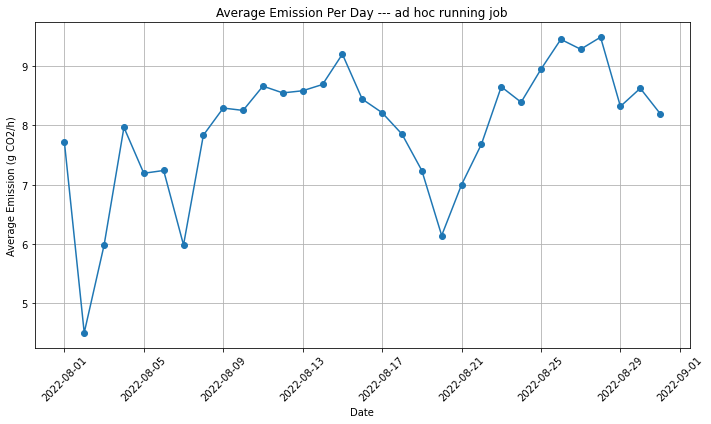

In [23]:
# Convert the 'completion_time' column to datetime
df_emission_jobs['completion_time'] = pd.to_datetime(df_emission_jobs['completion_time'])

# 提取日期部分并计算每日emission平均值
df_emission_jobs['date'] = df_emission_jobs['completion_time'].dt.date
df_avg_daily_emission = df_emission_jobs.groupby('date')['emission'].mean().reset_index()

# 绘制每日平均emission折线图
plt.figure(figsize=(10, 6))
plt.plot(df_avg_daily_emission['date'], df_avg_daily_emission['emission'], marker='o')
plt.xlabel('Date')
plt.ylabel('Average Emission (g CO2/h)')
plt.title('Average Emission Per Day --- ad hoc running jobs')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 显示图像
plt.show()

### carbon wareness running jobs - forecast error 0% 5% 10%

In [28]:
#forcast error 0%
def carbon_ware_error_0(current_time):
    # 判断条件
    if (current_time.weekday() < 5 and ((10 <= current_time.hour < 12) or (23 <= current_time.hour <= 24))) or \
       (current_time.weekday() >= 5 and ((8 <= current_time.hour <= 12) or (22 <= current_time.hour <= 24))):
#         print(current_time)
        return True
#     print(current_time)
    return False

In [82]:
#forcast error 5%
def carbon_ware_error_5(current_time):
    # 判断条件
    if (current_time.weekday() < 5 and ((11 <= current_time.hour < 16) or (23 <= current_time.hour <= 24))) or \
       (current_time.weekday() >= 5 and ((11 <= current_time.hour <= 12) or (22 <= current_time.hour <= 24))):
#         print(current_time)
        return True
#     print(current_time)
    return False

In [83]:
#forcast error 10%
def carbon_ware_error_10(current_time):
    # 判断条件
    if (current_time.weekday() < 5 and ((11 <= current_time.hour < 17) or (23 <= current_time.hour <= 24))) or \
       (current_time.weekday() >= 5 and ((11 <= current_time.hour <= 12) or (22 <= current_time.hour <= 24))):
#         print(current_time)
        return True
#     print(current_time)
    return False

In [86]:
# Linear model parameters
slope = 0.67
intercept = 34

# Generate job list
jobs = []
for _, group in input_trace_data.groupby(['NumberSequences', 'Task']):
    job_info = {
        'number_sequence': group.iloc[0]['NumberSequences'],
        'task': group.iloc[0]['Task'],
        'tasks': group.shape[0],  # Number of tasks for each job type
        'cpu_utilization': group.iloc[0]['%cpu'] / 100,  # Assume known CPU utilization
        'cpus': group.iloc[0]['cpus'],  # Number of CPUs for each job type
        'realtime': group.iloc[0]['Realtime'] / 60  # Convert seconds to minutes
    }
    jobs.append(job_info)

start_date = datetime(2022, 8, 1)
end_date = datetime(2022, 8, 31, 23, 59)

def simulate():
     # Initialize a list
    current_time = start_date + timedelta(hours=9)  # Set initial time to 9 AM on August 1, 2022
    running_jobs = []
    emission_jobs = []
    
    while current_time <= end_date or jobs or running_jobs:

        # Submit new jobs
        if submission(current_time):
            eligible_jobs = [job for job in jobs if job['realtime'] > 0]
            if eligible_jobs:
                job = random.choice(eligible_jobs)
                random_offset = random.randint(0, 29) * 30  # Random offset time, up to 29 intervals of 30 minutes
                submission_time = current_time + timedelta(minutes=random_offset)
                running_jobs.append({'job': job, 'submission_time': submission_time})
                print(f"New job submitted: NumberSequences {job['number_sequence']}, Task {job['task']}, Start time: {submission_time}")

                jobs.remove(job)  # Remove the submitted job from the list
            
        # Run jobs
        completed_jobs = []
        if carbon_ware_error_10(current_time):
            for job_info in running_jobs:
                job = job_info['job']
                submission_time = job_info['submission_time']
                task = job['task']
                if current_time >= submission_time and job['realtime'] > 0:  # Current time reaches or exceeds submission time, and there's remaining time for the task
                    power_consumption = (job['cpu_utilization'] * slope + intercept) / 1000 # unit:kW
                    emission = power_consumption * get_carbon_intensity_average(submission_time, current_time, carbon_intensity_202208)  # CO2/h
                    job['realtime'] -= 30  # Decrease remaining time for the task
                    if job['realtime'] <= 0:
                        completed_jobs.append({
                            'number_sequence': job['number_sequence'],
                            'task': task,
                            'completion_time': current_time,
                            'emission': emission
                        })
                        emission_jobs.append({
                            'number_sequence': job['number_sequence'],
                            'task': task,
                            'completion_time': current_time,
                            'emission': emission
                        })
                        running_jobs.remove(job_info)  # Remove the job from the list of running jobs
                        print(f"Job completed: NumberSequences {job['number_sequence']}, Task {task}, Completion time: {current_time}, Emission: {emission:.2f} g CO2/h")
                

        # Print completed job information
        for job in completed_jobs:
            print(f"Job completed: NumberSequences {job['number_sequence']}, Task {job['task']}, Completion time: {job['completion_time']}, Emission: {job['emission']:.2f} g CO2/h")
        current_time += timedelta(minutes=30)  # Increase time by 30 minutes, simulation step size

    return emission_jobs

### simulate - error 0

In [57]:
emission_jobs_error_0 = simulate()

New job submitted: NumberSequences 147000, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 09:00:00
New job submitted: NumberSequences 1970600, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-01 10:00:00
New job submitted: NumberSequences 985400, Task SORT_BAM, Start time: 2022-08-01 20:00:00
New job submitted: NumberSequences 31526800, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-01 14:00:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-01 21:00:00
New job submitted: NumberSequences 9399126, Task MERGED_LIB_BIGWIG, Start time: 2022-08-02 01:30:00
New job submitted: NumberSequences 73600, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 22:30:00
New job submitted: NumberSequences 75192126, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-01 14:00:00
New job submitted: NumberSequences 18798126, Task SORT_BAM, Start time: 2022-08-01 22:30:00
New job submitted: NumberSequences 9399126, Task MERGED_LIB_BAM, Start time: 2022-0

New job submitted: NumberSequences 61600, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-04 15:00:00
New job submitted: NumberSequences 492800, Task SORT_BAM, Start time: 2022-08-04 21:00:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-05 00:30:00
Job completed: NumberSequences 123200, Task MERGED_LIB_BAM, Completion time: 2022-08-04 11:30:00, Emission: 5.25 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_BAM, Completion time: 2022-08-04 11:30:00, Emission: 5.25 g CO2/h
New job submitted: NumberSequences 75192126, Task MERGED_LIB_ATAQV, Start time: 2022-08-04 12:00:00
New job submitted: NumberSequences 11980568, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-04 13:00:00
New job submitted: NumberSequences 492800, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-04 14:30:00
New job submitted: NumberSequences 7881800, Task MERGED_LIB_BAM, Start time: 2022-08-05 00:00:00
New job submitted: NumberSequences 3941

Job completed: NumberSequences 31526800, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-06 22:00:00, Emission: 6.82 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-06 22:30:00, Emission: 6.70 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-06 22:30:00, Emission: 6.70 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_ATAQV, Completion time: 2022-08-06 23:30:00, Emission: 6.85 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_ATAQV, Completion time: 2022-08-06 23:30:00, Emission: 6.85 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_MACS2, Completion time: 2022-08-07 09:30:00, Emission: 4.36 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-07 09:30:00, Emission: 5.17 g CO2/h
Job completed: NumberSequences 293800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time:

New job submitted: NumberSequences 147000, Task MERGED_LIB_MACS2, Start time: 2022-08-10 23:30:00
New job submitted: NumberSequences 2349800, Task TRIMGALORE, Start time: 2022-08-10 14:00:00
New job submitted: NumberSequences 246400, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-11 00:30:00
New job submitted: NumberSequences 61600, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-11 01:00:00
New job submitted: NumberSequences 9399126, Task SORT_BAM, Start time: 2022-08-11 03:00:00
New job submitted: NumberSequences 9399126, Task BWA_MEM, Start time: 2022-08-10 18:00:00
New job submitted: NumberSequences 147000, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-11 01:30:00
New job submitted: NumberSequences 75192126, Task MERGED_LIB_MACS2, Start time: 2022-08-10 18:00:00
New job submitted: NumberSequences 21027690, Task MERGED_LIB_MACS2, Start time: 2022-08-10 23:30:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_BAM, Start time: 2022-08-11 00:00:00
New job submitted:

Job completed: NumberSequences 3941000, Task FASTQC, Completion time: 2022-08-13 11:00:00, Emission: 7.61 g CO2/h
Job completed: NumberSequences 3941000, Task FASTQC, Completion time: 2022-08-13 11:00:00, Emission: 7.61 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-13 11:30:00, Emission: 4.83 g CO2/h
Job completed: NumberSequences 985400, Task TRIMGALORE, Completion time: 2022-08-13 11:30:00, Emission: 7.36 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-13 11:30:00, Emission: 4.83 g CO2/h
Job completed: NumberSequences 985400, Task TRIMGALORE, Completion time: 2022-08-13 11:30:00, Emission: 7.36 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-13 12:30:00, Emission: 6.40 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-13 12:30:00, Emission: 6.40 g CO2/h


Job completed: NumberSequences 61600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-15 23:00:00, Emission: 8.50 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-15 23:00:00, Emission: 8.96 g CO2/h
Job completed: NumberSequences 61600, Task SORT_BAM, Completion time: 2022-08-15 23:00:00, Emission: 8.92 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_ATAQV, Completion time: 2022-08-15 23:00:00, Emission: 8.98 g CO2/h
Job completed: NumberSequences 9399126, Task FASTQC, Completion time: 2022-08-15 23:00:00, Emission: 8.87 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-15 23:00:00, Emission: 8.50 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-15 23:00:00, Emission: 8.96 g CO2/h
Job completed: NumberSequences 61600, Task SORT_BAM, Completion time: 2022-08-15 23:00:00, Emission: 8.92 g C

Job completed: NumberSequences 62168398, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-18 23:00:00, Emission: 8.15 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-18 23:00:00, Emission: 7.44 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_MACS2, Completion time: 2022-08-18 23:00:00, Emission: 7.57 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-18 23:00:00, Emission: 6.74 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-18 23:00:00, Emission: 8.15 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-18 23:00:00, Emission: 7.44 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_MACS2, Completion time: 2022-08-18 23:00:00, Emission: 7.57 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 

Job completed: NumberSequences 61600, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-20 23:00:00, Emission: 5.52 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-20 23:00:00, Emission: 7.12 g CO2/h
Job completed: NumberSequences 147000, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-20 23:00:00, Emission: 6.00 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-20 23:00:00, Emission: 5.52 g CO2/h
Job completed: NumberSequences 1175000, Task BWA_MEM, Completion time: 2022-08-20 23:30:00, Emission: 7.50 g CO2/h
Job completed: NumberSequences 3941000, Task SORT_BAM, Completion time: 2022-08-20 23:30:00, Emission: 6.84 g CO2/h
Job completed: NumberSequences 1175000, Task BWA_MEM, Completion time: 2022-08-20 23:30:00, Emission: 7.50 g CO2/h
Job completed: NumberSequences 3941000, Task SORT_BAM, Completion time: 2022-08-20 23:30:00, Emission: 6.84 g CO2/h
Job completed: NumberSequen

Job completed: NumberSequences 246400, Task MERGED_LIB_ATAQV, Completion time: 2022-08-23 23:00:00, Emission: 9.57 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_ATAQV, Completion time: 2022-08-23 23:00:00, Emission: 9.57 g CO2/h
Job completed: NumberSequences 21027690, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-23 23:30:00, Emission: 9.98 g CO2/h
Job completed: NumberSequences 246400, Task SORT_BAM, Completion time: 2022-08-23 23:30:00, Emission: 8.54 g CO2/h
Job completed: NumberSequences 21027690, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-23 23:30:00, Emission: 9.98 g CO2/h
Job completed: NumberSequences 246400, Task SORT_BAM, Completion time: 2022-08-23 23:30:00, Emission: 8.54 g CO2/h
New job submitted: NumberSequences 246400, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-24 19:00:00
New job submitted: NumberSequences 147000, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-24 16:00:00
New job submitted: NumberSequences 73

Job completed: NumberSequences 61600, Task MERGED_LIB_BAM, Completion time: 2022-08-25 23:30:00, Emission: 9.30 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_BAM, Completion time: 2022-08-25 23:30:00, Emission: 9.30 g CO2/h
New job submitted: NumberSequences 15763400, Task FASTQC, Start time: 2022-08-26 11:30:00
New job submitted: NumberSequences 2349800, Task SORT_BAM, Start time: 2022-08-27 00:00:00
New job submitted: NumberSequences 2349800, Task FASTQC, Start time: 2022-08-26 22:30:00
New job submitted: NumberSequences 492800, Task FASTQC, Start time: 2022-08-26 15:00:00
Job completed: NumberSequences 985400, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-26 10:30:00, Emission: 7.98 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-26 10:30:00, Emission: 7.98 g CO2/h
New job submitted: NumberSequences 7881800, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-26 18:30:00
New job submitted: NumberSequences 73600, Task MER

Job completed: NumberSequences 37596126, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-28 10:00:00, Emission: 7.78 g CO2/h
Job completed: NumberSequences 7881800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-28 10:00:00, Emission: 8.55 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_ATAQV, Completion time: 2022-08-28 10:30:00, Emission: 7.81 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_ATAQV, Completion time: 2022-08-28 10:30:00, Emission: 7.81 g CO2/h
Job completed: NumberSequences 3941000, Task TRIMGALORE, Completion time: 2022-08-28 11:30:00, Emission: 8.13 g CO2/h
Job completed: NumberSequences 3941000, Task TRIMGALORE, Completion time: 2022-08-28 11:30:00, Emission: 8.13 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-28 12:00:00, Emission: 7.97 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-28 12:00:00, Emission: 7.97 g CO2/h

Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM, Completion time: 2022-08-31 10:30:00, Emission: 8.19 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_ATAQV, Completion time: 2022-08-31 10:30:00, Emission: 7.57 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-31 10:30:00, Emission: 7.47 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM, Completion time: 2022-08-31 10:30:00, Emission: 8.19 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_ATAQV, Completion time: 2022-08-31 10:30:00, Emission: 7.57 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-31 10:30:00, Emission: 7.47 g CO2/h
New job submitted: NumberSequences 1175000, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-31 19:00:00
Job completed: NumberSequences 492800, Task TRIMGALORE, Completion time: 2022-08-31 11:00:00, Emission: 7.95 g CO2/h
Job completed: NumberS

Job completed: NumberSequences 63053586, Task SORT_BAM, Completion time: 2022-09-04 10:00:00, Emission: 5.32 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-09-04 11:30:00, Emission: 7.31 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-09-04 11:30:00, Emission: 7.40 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-09-04 11:30:00, Emission: 7.31 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-09-04 11:30:00, Emission: 7.40 g CO2/h
Job completed: NumberSequences 18798126, Task FASTQC, Completion time: 2022-09-04 22:00:00, Emission: 7.14 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-09-04 22:00:00, Emission: 7.35 g CO2/h
Job completed: NumberSequences 18798126, Task FASTQC, Completion time: 2022-09-04 22:00:00,

Job completed: NumberSequences 147000, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-14 23:30:00, Emission: 9.33 g CO2/h
Job completed: NumberSequences 15763400, Task TRIMGALORE, Completion time: 2022-09-15 10:00:00, Emission: 7.97 g CO2/h
Job completed: NumberSequences 15763400, Task TRIMGALORE, Completion time: 2022-09-15 10:00:00, Emission: 7.97 g CO2/h
Job completed: NumberSequences 59743740, Task SORT_BAM, Completion time: 2022-09-15 23:30:00, Emission: 5.53 g CO2/h
Job completed: NumberSequences 59743740, Task SORT_BAM, Completion time: 2022-09-15 23:30:00, Emission: 5.53 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-16 23:00:00, Emission: 5.35 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-16 23:00:00, Emission: 5.35 g CO2/h
Job completed: NumberSequences 31526800, Task FASTQC, Completion time: 2022-09-17 08:00:00, Emission: 6.02 g CO2/h
Job completed: NumberSeq

Job completed: NumberSequences 21027690, Task MERGED_LIB_BAM, Completion time: 2022-10-03 23:30:00, Emission: 5.65 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_MACS2, Completion time: 2022-10-05 11:30:00, Emission: 6.79 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_MACS2, Completion time: 2022-10-05 11:30:00, Emission: 6.79 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-10-08 12:30:00, Emission: 6.66 g CO2/h
Job completed: NumberSequences 75192126, Task FASTQC, Completion time: 2022-10-08 12:30:00, Emission: 5.93 g CO2/h
Job completed: NumberSequences 1970600, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-10-08 12:30:00, Emission: 6.66 g CO2/h
Job completed: NumberSequences 75192126, Task FASTQC, Completion time: 2022-10-08 12:30:00, Emission: 5.93 g CO2/h
Job completed: NumberSequences 3941000, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-10-09 08:00:00, Emission: 6.38 g CO2/h
Job com

Job completed: NumberSequences 62168398, Task MERGED_LIB_BAM, Completion time: 2022-12-25 12:30:00, Emission: 7.58 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_BAM, Completion time: 2022-12-25 12:30:00, Emission: 7.58 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_BAM, Completion time: 2023-01-03 10:00:00, Emission: 8.32 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_BAM, Completion time: 2023-01-03 10:00:00, Emission: 8.32 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_BAM, Completion time: 2023-01-28 22:30:00, Emission: 9.04 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_BAM, Completion time: 2023-01-28 22:30:00, Emission: 9.04 g CO2/h
Job completed: NumberSequences 62168398, Task BWA_MEM, Completion time: 2023-02-10 23:00:00, Emission: 6.60 g CO2/h
Job completed: NumberSequences 62168398, Task BWA_MEM, Completion time: 2023-02-10 23:00:00, Emission: 6.60 g CO2/h
Job completed: NumberSequences

In [71]:
# Convert completed_jobs list to DataFrame
df_emission_jobs_error_0 = pd.DataFrame(emission_jobs_error_0)

# Convert 'completion_time' column to datetime
df_emission_jobs_error_0['completion_time'] = pd.to_datetime(df_emission_jobs_error_0['completion_time'])

# Filter out rows with completion dates in September

df_emission_jobs_error_0

,number_sequence,task,completion_time,emission,date
0,1970600,MERGED_LIB_BAM_FILTER,2022-08-01 23:00:00,6.119309,2022-08-01
1,985400,SORT_BAM,2022-08-02 11:00:00,5.663959,2022-08-02
2,587600,MERGED_LIB_ATAQV,2022-08-02 11:30:00,3.779616,2022-08-02
3,73600,MERGED_LIB_ATAQV,2022-08-02 23:30:00,3.715038,2022-08-02
4,985400,MERGED_LIB_ATAQV,2022-08-02 23:30:00,4.626775,2022-08-02
...,...,...,...,...,...
359,62168398,MERGED_LIB_BAM,2022-12-25 12:30:00,7.582354,2022-12-25
360,63053586,MERGED_LIB_BAM,2023-01-03 10:00:00,8.315882,2023-01-03
361,75192126,MERGED_LIB_BAM,2023-01-28 22:30:00,9.037362,2023-01-28
362,62168398,BWA_MEM,2023-02-10 23:00:00,6.598185,2023-02-10


In [73]:
# 按照 number_sequence 分组，并计算总和和平均值
df_emission_jobs_error_0_number_sequence = df_emission_jobs_error_0.groupby('number_sequence')['emission'].agg(['sum', 'mean']).reset_index()

df_emission_jobs_error_0_number_sequence.rename(columns={'sum': 'sum_error_0'}, inplace=True)
df_emission_jobs_error_0_number_sequence.rename(columns={'mean': 'mean_error_0'}, inplace=True)

df_emission_jobs_error_0_number_sequence

,number_sequence,sum_error_0,mean_error_0
0,61600,111.079822,7.934273
1,73600,110.220792,7.872914
2,123200,105.432895,7.530921
3,147000,101.490262,7.249304
4,246400,111.557330,7.968381
5,293800,95.706203,6.836157
6,492800,111.313875,7.950991
7,587600,106.488381,7.606313
8,985400,106.259830,7.589988
9,1175000,100.528767,7.180626


In [64]:
# df_emission_jobs_error_0 = df_emission_jobs_error_0[df_emission_jobs_error_0['completion_time'].dt.month == 8]

# # Convert the 'completion_time' column to datetime
# df_emission_jobs_error_0['completion_time'] = pd.to_datetime(df_emission_jobs_error_0['completion_time'])

# # 提取日期部分并计算每日emission平均值
# df_emission_jobs_error_0['date'] = df_emission_jobs_error_0['completion_time'].dt.date
# df_avg_daily_emission = df_emission_jobs_error_0.groupby('date')['emission'].mean().reset_index()

# # 绘制每日平均emission折线图
# plt.figure(figsize=(10, 6))
# plt.plot(df_avg_daily_emission['date'], df_avg_daily_emission['emission'], marker='o')
# plt.xlabel('Date')
# plt.ylabel('Average Emission (g CO2/h)')
# plt.title('Average Emission Per Day --- carbon wareness running time -- error 0%')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()

# # 显示图像
# plt.show()

### simulate - error 5

In [85]:
emission_jobs_error_5 = simulate()

New job submitted: NumberSequences 4699600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-01 12:30:00
New job submitted: NumberSequences 246400, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-01 16:30:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-01 16:30:00
New job submitted: NumberSequences 1970600, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-01 11:00:00
New job submitted: NumberSequences 1970600, Task MERGED_LIB_BAM, Start time: 2022-08-01 13:30:00
New job submitted: NumberSequences 73600, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-01 21:30:00
New job submitted: NumberSequences 63053586, Task FASTQC, Start time: 2022-08-01 14:00:00
New job submitted: NumberSequences 21027690, Task FASTQC, Start time: 2022-08-01 13:30:00
New job submitted: NumberSequences 11980568, Task SORT_BAM, Start time: 2022-08-01 15:30:00
Job completed: NumberSequences 1970600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-0

New job submitted: NumberSequences 11980568, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-03 20:30:00
New job submitted: NumberSequences 587600, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-03 20:30:00
Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-03 15:30:00, Emission: 7.39 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-03 15:30:00, Emission: 7.39 g CO2/h
New job submitted: NumberSequences 7881800, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-03 16:30:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-04 00:00:00
New job submitted: NumberSequences 1175000, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-04 17:00:00
New job submitted: NumberSequences 63053586, Task BWA_MEM, Start time: 2022-08-04 16:00:00
New job submitted: NumberSequences 293800, Task MERGED_LIB_ATAQV, Start time: 2022-08-04 18:30:00
New job sub

Job completed: NumberSequences 73600, Task TRIMGALORE, Completion time: 2022-08-06 12:30:00, Emission: 5.67 g CO2/h
Job completed: NumberSequences 73600, Task TRIMGALORE, Completion time: 2022-08-06 12:30:00, Emission: 5.67 g CO2/h
Job completed: NumberSequences 1175000, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-06 23:00:00, Emission: 6.45 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-06 23:00:00, Emission: 7.26 g CO2/h
Job completed: NumberSequences 1175000, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-06 23:00:00, Emission: 6.45 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-06 23:00:00, Emission: 7.26 g CO2/h
Job completed: NumberSequences 1175000, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-06 23:30:00, Emission: 7.08 g CO2/h
Job completed: NumberSequences 985400, Task FASTQC, Completion time: 2022-08-06 23:30:00, Emission: 6.75 g CO2/h
Job compl

New job submitted: NumberSequences 7881800, Task FASTQC, Start time: 2022-08-09 22:30:00
New job submitted: NumberSequences 62168398, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-10 03:30:00
New job submitted: NumberSequences 11980568, Task MERGED_LIB_ATAQV, Start time: 2022-08-10 05:30:00
New job submitted: NumberSequences 31526800, Task MERGED_LIB_ATAQV, Start time: 2022-08-09 18:00:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-10 03:30:00
New job submitted: NumberSequences 1970600, Task MERGED_LIB_ATAQV, Start time: 2022-08-09 22:00:00
Job completed: NumberSequences 1175000, Task FASTQC, Completion time: 2022-08-09 23:00:00, Emission: 8.88 g CO2/h
Job completed: NumberSequences 147000, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-09 23:00:00, Emission: 7.89 g CO2/h
Job completed: NumberSequences 1175000, Task FASTQC, Completion time: 2022-08-09 23:00:00, Emission: 8.88 g CO2/h
Job completed: NumberSequences 147000, Ta

Job completed: NumberSequences 123200, Task MERGED_LIB_BAM, Completion time: 2022-08-11 14:00:00, Emission: 8.11 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_BAM, Completion time: 2022-08-11 14:00:00, Emission: 8.11 g CO2/h
New job submitted: NumberSequences 59743740, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-11 15:30:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_BIGWIG, Start time: 2022-08-12 05:30:00
New job submitted: NumberSequences 63053586, Task MERGED_LIB_BAM, Start time: 2022-08-12 06:00:00
Job completed: NumberSequences 61600, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-11 15:30:00, Emission: 7.45 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-11 15:30:00, Emission: 7.45 g CO2/h
New job submitted: NumberSequences 15763400, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-11 18:00:00
New job submitted: NumberSequences 147000, Task MERGED_LIB_MACS2_ANNOTATE, St

Job completed: NumberSequences 4699600, Task SORT_BAM, Completion time: 2022-08-15 13:00:00, Emission: 8.04 g CO2/h
Job completed: NumberSequences 4699600, Task SORT_BAM, Completion time: 2022-08-15 13:00:00, Emission: 8.04 g CO2/h
New job submitted: NumberSequences 75192126, Task MERGED_LIB_BIGWIG, Start time: 2022-08-15 15:30:00
New job submitted: NumberSequences 9399126, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-15 14:00:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-16 00:00:00
New job submitted: NumberSequences 246400, Task BWA_MEM, Start time: 2022-08-15 19:00:00
Job completed: NumberSequences 59743740, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-15 15:00:00, Emission: 7.97 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-15 15:00:00, Emission: 7.97 g CO2/h
New job submitted: NumberSequences 63053586, Task MERGED_LIB_BAM_FILTER, Start time: 202

New job submitted: NumberSequences 9399126, Task FASTQC, Start time: 2022-08-17 18:00:00
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-17 15:00:00, Emission: 8.37 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-17 15:00:00, Emission: 8.37 g CO2/h
New job submitted: NumberSequences 985400, Task MERGED_LIB_BAM, Start time: 2022-08-18 03:30:00
New job submitted: NumberSequences 15763400, Task MERGED_LIB_BAM, Start time: 2022-08-17 19:30:00
New job submitted: NumberSequences 492800, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-18 00:30:00
Job completed: NumberSequences 63053586, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-17 23:00:00, Emission: 8.09 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_MACS2, Completion time: 2022-08-17 23:00:00, Emission: 8.92 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_PICARD_METRICS, Completi

New job submitted: NumberSequences 492800, Task MERGED_LIB_BAM, Start time: 2022-08-20 02:30:00
Job completed: NumberSequences 9399126, Task MERGED_LIB_BAM, Completion time: 2022-08-19 14:30:00, Emission: 4.72 g CO2/h
Job completed: NumberSequences 9399126, Task MERGED_LIB_BAM, Completion time: 2022-08-19 14:30:00, Emission: 4.72 g CO2/h
New job submitted: NumberSequences 61600, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-19 23:30:00
Job completed: NumberSequences 11980568, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-19 15:00:00, Emission: 7.41 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-19 15:00:00, Emission: 7.41 g CO2/h
New job submitted: NumberSequences 147000, Task SORT_BAM, Start time: 2022-08-20 00:30:00
Job completed: NumberSequences 18798126, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-19 15:30:00, Emission: 6.70 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_B

Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-22 13:30:00, Emission: 6.31 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-22 13:30:00, Emission: 6.31 g CO2/h
New job submitted: NumberSequences 18798126, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-23 01:30:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_ATAQV, Start time: 2022-08-23 02:00:00
New job submitted: NumberSequences 985400, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-22 21:00:00
New job submitted: NumberSequences 293800, Task MERGED_LIB_BAM, Start time: 2022-08-23 05:00:00
Job completed: NumberSequences 37596126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-22 15:30:00, Emission: 8.00 g CO2/h
Job completed: NumberSequences 37596126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-22 15:30:00, Emission: 8.00 g CO2/h
New job submitted: NumberSequences 37596126, Task MERGED_LIB_PIC

New job submitted: NumberSequences 31526800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-26 00:00:00
Job completed: NumberSequences 2349800, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-25 11:30:00, Emission: 8.21 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-25 11:30:00, Emission: 8.21 g CO2/h
New job submitted: NumberSequences 63053586, Task TRIMGALORE, Start time: 2022-08-25 18:00:00
Job completed: NumberSequences 31526800, Task SORT_BAM, Completion time: 2022-08-25 12:00:00, Emission: 8.46 g CO2/h
Job completed: NumberSequences 293800, Task BWA_MEM, Completion time: 2022-08-25 12:00:00, Emission: 8.16 g CO2/h
Job completed: NumberSequences 587600, Task MERGED_LIB_ATAQV, Completion time: 2022-08-25 12:00:00, Emission: 8.56 g CO2/h
Job completed: NumberSequences 31526800, Task SORT_BAM, Completion time: 2022-08-25 12:00:00, Emission: 8.46 g CO2/h
Job completed: NumberSequences 293800, Task BWA_MEM, Comp

Job completed: NumberSequences 18798126, Task FASTQC, Completion time: 2022-08-26 23:30:00, Emission: 9.48 g CO2/h
Job completed: NumberSequences 587600, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-26 23:30:00, Emission: 8.51 g CO2/h
Job completed: NumberSequences 21027690, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-26 23:30:00, Emission: 8.56 g CO2/h
Job completed: NumberSequences 587600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-27 23:00:00, Emission: 9.51 g CO2/h
Job completed: NumberSequences 587600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-27 23:00:00, Emission: 9.51 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_BAM, Completion time: 2022-08-27 23:30:00, Emission: 8.02 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_BAM, Completion time: 2022-08-27 23:30:00, Emission: 8.02 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-28 12:00:00, Emissio

New job submitted: NumberSequences 3941000, Task MERGED_LIB_BIGWIG, Start time: 2022-08-30 21:30:00
Job completed: NumberSequences 7881800, Task BWA_MEM, Completion time: 2022-08-30 12:00:00, Emission: 9.18 g CO2/h
Job completed: NumberSequences 7881800, Task BWA_MEM, Completion time: 2022-08-30 12:00:00, Emission: 9.18 g CO2/h
New job submitted: NumberSequences 9399126, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-30 13:00:00
New job submitted: NumberSequences 2349800, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-30 15:30:00
Job completed: NumberSequences 1175000, Task BWA_MEM, Completion time: 2022-08-30 13:00:00, Emission: 9.56 g CO2/h
Job completed: NumberSequences 1175000, Task BWA_MEM, Completion time: 2022-08-30 13:00:00, Emission: 9.56 g CO2/h
New job submitted: NumberSequences 7881800, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-30 20:00:00
New job submitted: NumberSequences 18798126, Task BWA_MEM, Start time: 2022-08-30 23:30:00
Job completed: NumberSequenc

Job completed: NumberSequences 73600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-31 23:30:00, Emission: 7.40 g CO2/h
Job completed: NumberSequences 73600, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-31 23:30:00, Emission: 7.40 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-09-01 11:00:00, Emission: 7.89 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-01 11:00:00, Emission: 7.92 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-09-01 11:00:00, Emission: 7.89 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-01 11:00:00, Emission: 7.92 g CO2/h
Job completed: NumberSequences 37596126, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-09-01 11:30:00, Emission: 7.32 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_BIGWIG, Completion time:

Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-07 23:30:00, Emission: 9.96 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-09-07 23:30:00, Emission: 8.35 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-07 23:30:00, Emission: 9.96 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-09-07 23:30:00, Emission: 8.35 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-08 12:00:00, Emission: 9.49 g CO2/h
Job completed: NumberSequences 123200, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-08 12:00:00, Emission: 9.49 g CO2/h
Job completed: NumberSequences 9399126, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-09-08 12:30:00, Emission: 8.49 g CO2/h
Job completed: NumberSequences 9399126, Task MERGED_LIB_BAM_FILTER, Completion time: 20

Job completed: NumberSequences 62168398, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-24 12:30:00, Emission: 7.63 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-24 12:30:00, Emission: 7.63 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-24 23:00:00, Emission: 7.85 g CO2/h
Job completed: NumberSequences 15763400, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-24 23:00:00, Emission: 7.85 g CO2/h
Job completed: NumberSequences 63053586, Task SORT_BAM, Completion time: 2022-09-25 12:30:00, Emission: 6.63 g CO2/h
Job completed: NumberSequences 63053586, Task SORT_BAM, Completion time: 2022-09-25 12:30:00, Emission: 6.63 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-27 23:00:00, Emission: 8.72 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-27 23:00:00, Emi

Job completed: NumberSequences 59743740, Task BWA_MEM, Completion time: 2022-11-08 11:30:00, Emission: 10.09 g CO2/h
Job completed: NumberSequences 59743740, Task BWA_MEM, Completion time: 2022-11-08 11:30:00, Emission: 10.09 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-11-10 23:30:00, Emission: 8.11 g CO2/h
Job completed: NumberSequences 75192126, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-11-10 23:30:00, Emission: 8.11 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BAM, Completion time: 2022-11-14 13:30:00, Emission: 6.59 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BAM, Completion time: 2022-11-14 13:30:00, Emission: 6.59 g CO2/h
Job completed: NumberSequences 37596126, Task BWA_MEM, Completion time: 2022-11-21 11:30:00, Emission: 9.76 g CO2/h
Job completed: NumberSequences 37596126, Task BWA_MEM, Completion time: 2022-11-21 11:30:00, Emission: 9.76 g CO2/h
Job completed: NumberSequenc

In [87]:
# Convert completed_jobs list to DataFrame
df_emission_jobs_error_5 = pd.DataFrame(emission_jobs_error_5)

# Convert 'completion_time' column to datetime
df_emission_jobs_error_5['completion_time'] = pd.to_datetime(df_emission_jobs_error_5['completion_time'])

df_emission_jobs_error_5

,number_sequence,task,completion_time,emission
0,1970600,MERGED_LIB_BAM_FILTER,2022-08-01 13:00:00,8.094972
1,123200,MERGED_LIB_BAM_REMOVE_ORPHAN,2022-08-01 23:00:00,5.497935
2,246400,SORT_BAM,2022-08-02 11:30:00,3.525544
3,492800,MERGED_LIB_ATAQV,2022-08-02 13:00:00,3.627096
4,123200,TRIMGALORE,2022-08-02 14:00:00,3.874246
...,...,...,...,...
359,63053586,MERGED_LIB_BAM,2022-11-22 13:30:00,8.962284
360,62168398,MERGED_LIB_BAM,2022-11-23 12:30:00,6.636749
361,75192126,MERGED_LIB_BAM,2022-12-19 15:30:00,8.827597
362,62168398,BWA_MEM,2023-01-12 23:00:00,8.581568


In [89]:
# 按照 number_sequence 分组，并计算总和和平均值
df_emission_jobs_error_5_number_sequence = df_emission_jobs_error_5.groupby('number_sequence')['emission'].agg(['sum', 'mean']).reset_index()

df_emission_jobs_error_5_number_sequence.rename(columns={'sum': 'sum_error_5'}, inplace=True)
df_emission_jobs_error_5_number_sequence.rename(columns={'mean': 'mean_error_5'}, inplace=True)

df_emission_jobs_error_5_number_sequence

,number_sequence,sum_error_5,mean_error_5
0,61600,108.201745,7.728696
1,73600,99.224173,7.087441
2,123200,98.129876,7.009277
3,147000,100.017869,7.144134
4,246400,104.626229,7.473302
5,293800,111.250634,7.946474
6,492800,104.934976,7.495355
7,587600,111.302083,7.950149
8,985400,106.032831,7.573774
9,1175000,112.915585,8.065399


### simulate - error 10

In [95]:
emission_jobs_error_10 = simulate()

New job submitted: NumberSequences 1970600, Task MERGED_LIB_MACS2, Start time: 2022-08-01 15:30:00
New job submitted: NumberSequences 7881800, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 13:00:00
New job submitted: NumberSequences 73600, Task MERGED_LIB_ATAQV, Start time: 2022-08-01 18:00:00
New job submitted: NumberSequences 37596126, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-01 18:30:00
New job submitted: NumberSequences 985400, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-01 22:00:00
New job submitted: NumberSequences 61600, Task BWA_MEM, Start time: 2022-08-01 16:00:00
New job submitted: NumberSequences 75192126, Task MERGED_LIB_ATAQV, Start time: 2022-08-01 16:30:00
New job submitted: NumberSequences 61600, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-01 21:30:00
New job submitted: NumberSequences 11980568, Task TRIMGALORE, Start time: 2022-08-01 17:00:00
New job submitted: NumberSequences 61600, Task MERGED_LIB_ATAQV, Start time: 2022-08-01 15:30:00
New j

New job submitted: NumberSequences 246400, Task MERGED_LIB_MACS2, Start time: 2022-08-04 06:30:00
New job submitted: NumberSequences 2349800, Task TRIMGALORE, Start time: 2022-08-04 18:30:00
New job submitted: NumberSequences 31526800, Task SORT_BAM, Start time: 2022-08-04 20:30:00
New job submitted: NumberSequences 1970600, Task FASTQC, Start time: 2022-08-04 15:30:00
New job submitted: NumberSequences 11980568, Task MERGED_LIB_BIGWIG, Start time: 2022-08-04 20:30:00
New job submitted: NumberSequences 3941000, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-05 00:30:00
Job completed: NumberSequences 246400, Task MERGED_LIB_MACS2, Completion time: 2022-08-04 11:00:00, Emission: 7.51 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_MACS2, Completion time: 2022-08-04 11:00:00, Emission: 7.51 g CO2/h
New job submitted: NumberSequences 31526800, Task MERGED_LIB_PLOTFINGERPRINT, Start time: 2022-08-04 20:00:00
Job completed: NumberSequences 73600, Task FASTQC, Completio

Job completed: NumberSequences 4699600, Task MERGED_LIB_MACS2, Completion time: 2022-08-07 11:00:00, Emission: 6.14 g CO2/h
Job completed: NumberSequences 985400, Task TRIMGALORE, Completion time: 2022-08-07 11:00:00, Emission: 5.03 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_MACS2, Completion time: 2022-08-07 11:00:00, Emission: 6.14 g CO2/h
Job completed: NumberSequences 985400, Task TRIMGALORE, Completion time: 2022-08-07 11:00:00, Emission: 5.03 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-07 22:00:00, Emission: 9.17 g CO2/h
Job completed: NumberSequences 293800, Task BWA_MEM, Completion time: 2022-08-07 22:00:00, Emission: 7.61 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-07 22:00:00, Emission: 9.17 g CO2/h
Job completed: NumberSequences 293800, Task BWA_MEM, Completion time: 2022-08-07 22:00:00, Emission: 7.61 g CO2/h
Job completed: Numbe

Job completed: NumberSequences 73600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-09 23:30:00, Emission: 8.56 g CO2/h
Job completed: NumberSequences 1175000, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-09 23:30:00, Emission: 8.43 g CO2/h
Job completed: NumberSequences 73600, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-09 23:30:00, Emission: 8.56 g CO2/h
New job submitted: NumberSequences 4699600, Task MERGED_LIB_ATAQV, Start time: 2022-08-10 22:30:00
New job submitted: NumberSequences 62168398, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-10 13:00:00
New job submitted: NumberSequences 62168398, Task FASTQC, Start time: 2022-08-10 16:30:00
New job submitted: NumberSequences 7881800, Task BWA_MEM, Start time: 2022-08-10 18:00:00
New job submitted: NumberSequences 7881800, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-10 19:30:00
Job completed: NumberSequences 147000, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-10

New job submitted: NumberSequences 75192126, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-13 02:00:00
Job completed: NumberSequences 11980568, Task TRIMGALORE, Completion time: 2022-08-12 12:30:00, Emission: 7.49 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-12 12:30:00, Emission: 7.67 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_ATAQV, Completion time: 2022-08-12 12:30:00, Emission: 8.19 g CO2/h
Job completed: NumberSequences 11980568, Task TRIMGALORE, Completion time: 2022-08-12 12:30:00, Emission: 7.49 g CO2/h
Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-12 12:30:00, Emission: 7.67 g CO2/h
Job completed: NumberSequences 4699600, Task MERGED_LIB_ATAQV, Completion time: 2022-08-12 12:30:00, Emission: 8.19 g CO2/h
New job submitted: NumberSequences 61600, Task FASTQC, Start time: 2022-08-12 19:30:00
New job submitted: NumberSequences 293800, Task MERGED_LIB_MACS2

Job completed: NumberSequences 2349800, Task MERGED_LIB_BAM, Completion time: 2022-08-15 15:30:00, Emission: 8.84 g CO2/h
New job submitted: NumberSequences 63053586, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-16 05:00:00
Job completed: NumberSequences 31526800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-15 16:00:00, Emission: 8.36 g CO2/h
Job completed: NumberSequences 31526800, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-08-15 16:00:00, Emission: 8.36 g CO2/h
New job submitted: NumberSequences 123200, Task MERGED_LIB_BAM, Start time: 2022-08-15 16:30:00
Job completed: NumberSequences 31526800, Task SORT_BAM, Completion time: 2022-08-15 16:30:00, Emission: 8.85 g CO2/h
Job completed: NumberSequences 31526800, Task SORT_BAM, Completion time: 2022-08-15 16:30:00, Emission: 8.85 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Completion time: 2022-08-15 23:00:00, Emission: 8.63 g CO2/h
Job completed: NumberSequences 985400, Ta

Job completed: NumberSequences 9399126, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-17 16:00:00, Emission: 8.27 g CO2/h
New job submitted: NumberSequences 4699600, Task MERGED_LIB_BIGWIG, Start time: 2022-08-18 04:30:00
Job completed: NumberSequences 59743740, Task MERGED_LIB_ATAQV, Completion time: 2022-08-17 16:30:00, Emission: 7.90 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_ATAQV, Completion time: 2022-08-17 16:30:00, Emission: 7.90 g CO2/h
Job completed: NumberSequences 15763400, Task FASTQC, Completion time: 2022-08-17 23:00:00, Emission: 8.64 g CO2/h
Job completed: NumberSequences 147000, Task SORT_BAM, Completion time: 2022-08-17 23:00:00, Emission: 8.78 g CO2/h
Job completed: NumberSequences 15763400, Task FASTQC, Completion time: 2022-08-17 23:00:00, Emission: 8.64 g CO2/h
Job completed: NumberSequences 147000, Task SORT_BAM, Completion time: 2022-08-17 23:00:00, Emission: 8.78 g CO2/h
New job submitted: NumberSequences 4699600, Task MERGED_L

Job completed: NumberSequences 2349800, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-19 14:00:00, Emission: 7.28 g CO2/h
New job submitted: NumberSequences 2349800, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-20 02:00:00
Job completed: NumberSequences 63053586, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-19 14:30:00, Emission: 7.32 g CO2/h
Job completed: NumberSequences 1175000, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-19 14:30:00, Emission: 7.04 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_BAM, Completion time: 2022-08-19 14:30:00, Emission: 5.96 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_BIGWIG, Completion time: 2022-08-19 14:30:00, Emission: 7.32 g CO2/h
Job completed: NumberSequences 1175000, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-19 14:30:00, Emission: 7.04 g CO2/h
Job completed: NumberSequences 61600, Task MERGED_LIB_BAM, Completion time: 2022-08-19 14:30:00, Emission: 5.96 g CO2/h


Job completed: NumberSequences 62168398, Task MERGED_LIB_ATAQV, Completion time: 2022-08-22 14:00:00, Emission: 7.54 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_BAM, Completion time: 2022-08-22 14:00:00, Emission: 7.43 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_ATAQV, Completion time: 2022-08-22 14:00:00, Emission: 7.54 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_BAM, Completion time: 2022-08-22 14:00:00, Emission: 7.43 g CO2/h
New job submitted: NumberSequences 587600, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-22 23:00:00
New job submitted: NumberSequences 7881800, Task MERGED_LIB_BAM, Start time: 2022-08-22 16:30:00
Job completed: NumberSequences 3941000, Task FASTQC, Completion time: 2022-08-22 15:00:00, Emission: 7.39 g CO2/h
Job completed: NumberSequences 3941000, Task FASTQC, Completion time: 2022-08-22 15:00:00, Emission: 7.39 g CO2/h
New job submitted: NumberSequences 3941000, Task MERGED_LIB_MACS2, Start tim

Job completed: NumberSequences 21027690, Task FASTQC, Completion time: 2022-08-24 14:00:00, Emission: 7.85 g CO2/h
Job completed: NumberSequences 21027690, Task FASTQC, Completion time: 2022-08-24 14:00:00, Emission: 7.85 g CO2/h
New job submitted: NumberSequences 62168398, Task BWA_MEM, Start time: 2022-08-24 16:00:00
New job submitted: NumberSequences 75192126, Task FASTQC, Start time: 2022-08-24 22:30:00
Job completed: NumberSequences 37596126, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-24 15:00:00, Emission: 7.64 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-08-24 15:00:00, Emission: 6.37 g CO2/h
Job completed: NumberSequences 246400, Task MERGED_LIB_ATAQV, Completion time: 2022-08-24 15:00:00, Emission: 7.45 g CO2/h
Job completed: NumberSequences 37596126, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-24 15:00:00, Emission: 7.64 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_PICARD_

Job completed: NumberSequences 18798126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-26 13:00:00, Emission: 8.72 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-26 13:00:00, Emission: 8.72 g CO2/h
New job submitted: NumberSequences 9399126, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-26 19:30:00
Job completed: NumberSequences 11980568, Task SORT_BAM, Completion time: 2022-08-26 13:30:00, Emission: 8.70 g CO2/h
Job completed: NumberSequences 11980568, Task SORT_BAM, Completion time: 2022-08-26 13:30:00, Emission: 8.70 g CO2/h
New job submitted: NumberSequences 15763400, Task MERGED_LIB_MACS2, Start time: 2022-08-27 03:00:00
New job submitted: NumberSequences 73600, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-27 00:00:00
Job completed: NumberSequences 21027690, Task TRIMGALORE, Completion time: 2022-08-26 14:30:00, Emission: 9.47 g CO2/h
Job completed: NumberSequences 985400, Task MERGED_LIB_BIGWIG, Comp

New job submitted: NumberSequences 73600, Task MERGED_LIB_BAM_FILTER, Start time: 2022-08-29 20:30:00
New job submitted: NumberSequences 587600, Task MERGED_LIB_PLOTPROFILE, Start time: 2022-08-30 01:30:00
New job submitted: NumberSequences 246400, Task MERGED_LIB_BAM, Start time: 2022-08-30 02:30:00
Job completed: NumberSequences 59743740, Task FASTQC, Completion time: 2022-08-29 15:00:00, Emission: 8.13 g CO2/h
Job completed: NumberSequences 59743740, Task FASTQC, Completion time: 2022-08-29 15:00:00, Emission: 8.13 g CO2/h
New job submitted: NumberSequences 492800, Task MERGED_LIB_ATAQV, Start time: 2022-08-29 21:30:00
New job submitted: NumberSequences 492800, Task MERGED_LIB_BAM_REMOVE_ORPHAN, Start time: 2022-08-29 16:30:00
Job completed: NumberSequences 11980568, Task MERGED_LIB_MACS2_ANNOTATE, Completion time: 2022-08-29 16:00:00, Emission: 7.42 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_PLOTFINGERPRINT, Completion time: 2022-08-29 16:00:00, Emission: 9.61

Job completed: NumberSequences 123200, Task BWA_MEM, Completion time: 2022-08-31 12:30:00, Emission: 8.27 g CO2/h
Job completed: NumberSequences 123200, Task BWA_MEM, Completion time: 2022-08-31 12:30:00, Emission: 8.27 g CO2/h
New job submitted: NumberSequences 31526800, Task MERGED_LIB_ATAQV, Start time: 2022-08-31 13:30:00
Job completed: NumberSequences 147000, Task TRIMGALORE, Completion time: 2022-08-31 13:00:00, Emission: 8.11 g CO2/h
Job completed: NumberSequences 147000, Task TRIMGALORE, Completion time: 2022-08-31 13:00:00, Emission: 8.11 g CO2/h
New job submitted: NumberSequences 61600, Task MERGED_LIB_MACS2_ANNOTATE, Start time: 2022-08-31 15:00:00
New job submitted: NumberSequences 21027690, Task MERGED_LIB_PICARD_METRICS, Start time: 2022-08-31 15:30:00
Job completed: NumberSequences 246400, Task BWA_MEM, Completion time: 2022-08-31 14:00:00, Emission: 8.47 g CO2/h
Job completed: NumberSequences 246400, Task BWA_MEM, Completion time: 2022-08-31 14:00:00, Emission: 8.47 g C

Job completed: NumberSequences 31526800, Task TRIMGALORE, Completion time: 2022-09-04 23:30:00, Emission: 7.05 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-05 12:00:00, Emission: 8.08 g CO2/h
Job completed: NumberSequences 62168398, Task FASTQC, Completion time: 2022-09-05 12:00:00, Emission: 7.58 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_ATAQV, Completion time: 2022-09-05 12:00:00, Emission: 8.03 g CO2/h
Job completed: NumberSequences 11980568, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-05 12:00:00, Emission: 8.08 g CO2/h
Job completed: NumberSequences 62168398, Task FASTQC, Completion time: 2022-09-05 12:00:00, Emission: 7.58 g CO2/h
Job completed: NumberSequences 63053586, Task MERGED_LIB_ATAQV, Completion time: 2022-09-05 12:00:00, Emission: 8.03 g CO2/h
Job completed: NumberSequences 9399126, Task TRIMGALORE, Completion time: 2022-09-05 12:30:00, Emission: 9.57 g CO2/h
Job completed: Number

Job completed: NumberSequences 18798126, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-15 13:00:00, Emission: 7.84 g CO2/h
Job completed: NumberSequences 18798126, Task MERGED_LIB_PLOTPROFILE, Completion time: 2022-09-15 13:00:00, Emission: 7.84 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-09-15 15:00:00, Emission: 7.25 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_PICARD_METRICS, Completion time: 2022-09-15 15:00:00, Emission: 7.25 g CO2/h
Job completed: NumberSequences 63053586, Task FASTQC, Completion time: 2022-09-15 16:30:00, Emission: 7.16 g CO2/h
Job completed: NumberSequences 37596126, Task SORT_BAM, Completion time: 2022-09-15 16:30:00, Emission: 7.97 g CO2/h
Job completed: NumberSequences 63053586, Task FASTQC, Completion time: 2022-09-15 16:30:00, Emission: 7.16 g CO2/h
Job completed: NumberSequences 37596126, Task SORT_BAM, Completion time: 2022-09-15 16:30:00, Emission: 7.97 g CO2/h
Job co

Job completed: NumberSequences 31526800, Task BWA_MEM, Completion time: 2022-10-14 12:00:00, Emission: 8.98 g CO2/h
Job completed: NumberSequences 31526800, Task BWA_MEM, Completion time: 2022-10-14 12:00:00, Emission: 8.98 g CO2/h
Job completed: NumberSequences 59743740, Task TRIMGALORE, Completion time: 2022-10-18 14:00:00, Emission: 10.06 g CO2/h
Job completed: NumberSequences 59743740, Task TRIMGALORE, Completion time: 2022-10-18 14:00:00, Emission: 10.06 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BAM, Completion time: 2022-10-26 16:00:00, Emission: 3.69 g CO2/h
Job completed: NumberSequences 59743740, Task MERGED_LIB_BAM, Completion time: 2022-10-26 16:00:00, Emission: 3.69 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-10-26 23:30:00, Emission: 9.23 g CO2/h
Job completed: NumberSequences 62168398, Task MERGED_LIB_BAM_FILTER, Completion time: 2022-10-26 23:30:00, Emission: 9.23 g CO2/h
Job completed: NumberS

In [97]:
#  Convert completed_jobs list to DataFrame
df_emission_jobs_error_10 = pd.DataFrame(emission_jobs_error_10)

# Convert 'completion_time' column to datetime
df_emission_jobs_error_10['completion_time'] = pd.to_datetime(df_emission_jobs_error_10['completion_time'])

df_emission_jobs_error_10

,number_sequence,task,completion_time,emission
0,61600,MERGED_LIB_ATAQV,2022-08-01 15:30:00,7.468461
1,1970600,MERGED_LIB_MACS2,2022-08-01 16:30:00,7.392447
2,73600,MERGED_LIB_ATAQV,2022-08-01 23:30:00,5.428981
3,147000,MERGED_LIB_ATAQV,2022-08-01 23:30:00,5.352488
4,61600,BWA_MEM,2022-08-02 11:00:00,5.707449
...,...,...,...,...
359,63053586,BWA_MEM,2022-11-09 23:00:00,6.557903
360,63053586,MERGED_LIB_BAM,2022-11-13 23:00:00,9.154458
361,75192126,MERGED_LIB_BAM,2022-11-29 14:30:00,8.547911
362,62168398,BWA_MEM,2022-12-21 14:00:00,8.660118


In [98]:
# 按照 number_sequence 分组，并计算总和和平均值
df_emission_jobs_error_10_number_sequence = df_emission_jobs_error_10.groupby('number_sequence')['emission'].agg(['sum', 'mean']).reset_index()

df_emission_jobs_error_10_number_sequence.rename(columns={'sum': 'sum_error_10'}, inplace=True)
df_emission_jobs_error_10_number_sequence.rename(columns={'mean': 'mean_error_10'}, inplace=True)

df_emission_jobs_error_10_number_sequence

,number_sequence,sum_error_10,mean_error_10
0,61600,108.795105,7.771079
1,73600,108.479849,7.748561
2,123200,104.172965,7.440926
3,147000,112.679444,8.048532
4,246400,113.488265,8.106305
5,293800,101.294549,7.235325
6,492800,113.993485,8.142392
7,587600,99.405244,7.100375
8,985400,103.030506,7.359322
9,1175000,105.571762,7.540840


## compare the result

In [113]:
# 使用 merge() 函数进行合并
merged_df = pd.merge(df_emission_jobs_number_sequence, df_emission_jobs_error_0_number_sequence, on='number_sequence')
merged_df = pd.merge(merged_df, df_emission_jobs_error_5_number_sequence, on='number_sequence')
merged_df = pd.merge(merged_df, df_emission_jobs_error_10_number_sequence, on='number_sequence')

merged_df['saved_sum%_0'] = (merged_df['sum'] - merged_df['sum_error_0']) / merged_df['sum'] * 100
merged_df['saved_mean%_0'] = (merged_df['mean'] - merged_df['mean_error_0']) / merged_df['mean'] * 100

merged_df['saved_sum%_5'] = (merged_df['sum'] - merged_df['sum_error_5']) / merged_df['sum'] * 100
merged_df['saved_mean%_5'] = (merged_df['mean'] - merged_df['mean_error_5']) / merged_df['mean'] * 100

merged_df['saved_sum%_10'] = (merged_df['sum'] - merged_df['sum_error_10']) / merged_df['sum'] * 100
merged_df['saved_mean%_10'] = (merged_df['mean'] - merged_df['mean_error_10']) / merged_df['mean'] * 100

# 将小于 0 的值替换为 0
merged_df[merged_df < 0] = 0

In [128]:
merged_df

,number_sequence,sum,mean,sum_error_0,mean_error_0,sum_error_5,mean_error_5,sum_error_10,mean_error_10,saved_sum%_0,saved_mean%_0,saved_sum%_5,saved_mean%_5,saved_sum%_10,saved_mean%_10
0,61600,115.511728,8.250838,111.079822,7.934273,108.201745,7.728696,108.795105,7.771079,3.836758,3.836758,6.328347,6.328347,5.814667,5.814667
1,73600,116.642500,8.331607,110.220792,7.872914,99.224173,7.087441,108.479849,7.748561,5.505462,5.505462,14.933088,14.933088,6.998008,6.998008
2,123200,113.889842,8.134989,105.432895,7.530921,98.129876,7.009277,104.172965,7.440926,7.425550,7.425550,13.837904,13.837904,8.531821,8.531821
3,147000,105.179463,7.512819,101.490262,7.249304,100.017869,7.144134,112.679444,8.048532,3.507530,3.507530,4.907416,4.907416,0.000000,0.000000
4,246400,116.531485,8.323678,111.557330,7.968381,104.626229,7.473302,113.488265,8.106305,4.268507,4.268507,10.216343,10.216343,2.611501,2.611501
5,293800,117.716660,8.408333,95.706203,6.836157,111.250634,7.946474,101.294549,7.235325,18.697827,18.697827,5.492873,5.492873,13.950541,13.950541
6,492800,121.103144,8.650225,111.313875,7.950991,104.934976,7.495355,113.993485,8.142392,8.083415,8.083415,13.350742,13.350742,5.870748,5.870748
7,587600,103.812078,7.415148,106.488381,7.606313,111.302083,7.950149,99.405244,7.100375,0.000000,0.000000,0.000000,0.000000,4.245011,4.245011
8,985400,118.188380,8.442027,106.259830,7.589988,106.032831,7.573774,103.030506,7.359322,10.092828,10.092828,10.284893,10.284893,12.825181,12.825181
9,1175000,105.168232,7.512017,100.528767,7.180626,112.915585,8.065399,105.571762,7.540840,4.411470,4.411470,0.000000,0.000000,0.000000,0.000000


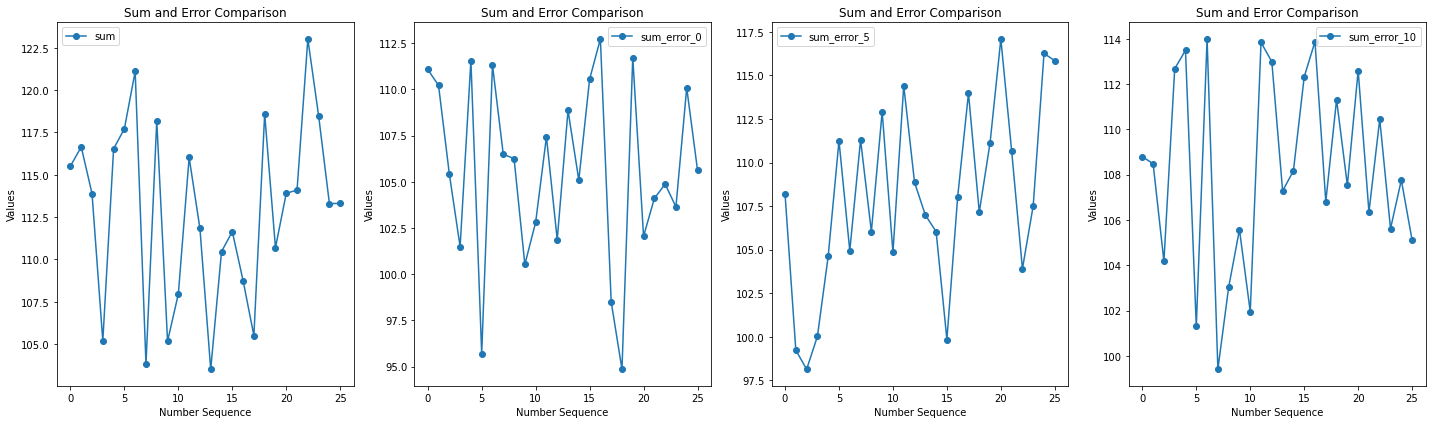

In [132]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))  # 创建一行四列的子图

axs[0].plot(merged_df.index, merged_df['sum'], marker='o', label='sum')
axs[1].plot(merged_df.index, merged_df['sum_error_0'], marker='o', label='sum_error_0')
axs[2].plot(merged_df.index, merged_df['sum_error_5'], marker='o', label='sum_error_5')
axs[3].plot(merged_df.index, merged_df['sum_error_10'], marker='o', label='sum_error_10')

# 添加标题和标签
for ax in axs:
    ax.set_title('Sum and Error Comparison')
    ax.set_xlabel('Number Sequence')
    ax.set_ylabel('Values')

# 添加图例
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

# 自动调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

In [115]:
merged_df.to_csv('result_emssion_saved.csv', index=False)

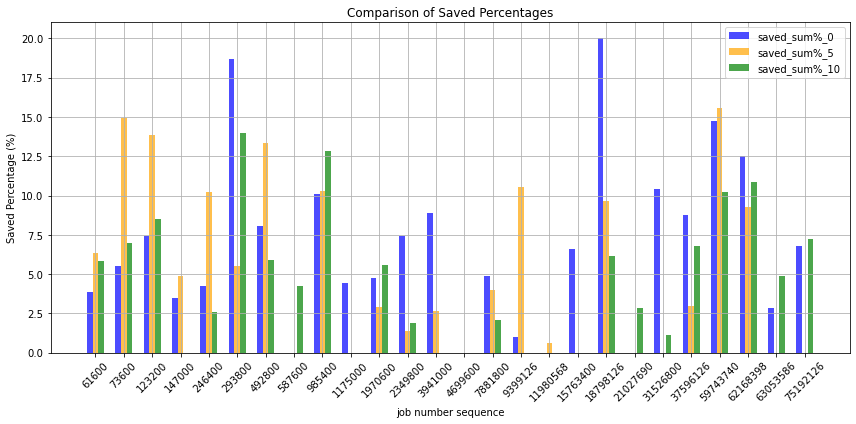

In [122]:
# 生成 x 坐标
x = np.arange(len(merged_df))

# 绘制直方图
plt.figure(figsize=(12, 6))
bar_width = 0.2

plt.bar(x - bar_width, merged_df["saved_sum%_0"], width=bar_width, label="saved_sum%_0", color="blue", alpha=0.7)
plt.bar(x, merged_df["saved_sum%_5"], width=bar_width, label="saved_sum%_5", color="orange", alpha=0.7)
plt.bar(x + bar_width, merged_df["saved_sum%_10"], width=bar_width, label="saved_sum%_10", color="green", alpha=0.7)

plt.xlabel("job number sequence")
plt.ylabel("Saved Percentage (%)")
plt.title("Comparison of Saved Percentages")
plt.legend()
plt.grid(True)
plt.xticks(x, merged_df["number_sequence"], rotation=45)  # 设置 x 轴标签和旋转
plt.tight_layout()  # 自动调整布局，防止标签被裁剪
plt.show()



In [127]:
sum_sum = merged_df["sum"].sum()
sum_error_0_sum = merged_df["sum_error_0"].sum()
sum_error_5_sum = merged_df["sum_error_5"].sum()
sum_error_10_sum = merged_df["sum_error_10"].sum()

print('ad hoc running all jobs emissions(CO2/h):',sum_sum)
print('carbon-awareness(error 0%) running all jobs emissions(CO2/h):',sum_error_0_sum)
print('carbon-awareness(error 5%) running all jobs emissions(CO2/h):',sum_error_5_sum)
print('carbon-awareness(error 10%) running all jobs emissions(CO2/h):',sum_error_10_sum)

print('-------------------------------')
saved_sum_error_0 = (sum_sum - sum_error_0_sum) / sum_sum * 100
saved_sum_error_5 = (sum_sum - sum_error_5_sum) / sum_sum * 100
saved_sum_error_10 = (sum_sum - sum_error_10_sum) / sum_sum * 100

print('the forecast error 0% data saved emission%: ',saved_sum_error_0)
print('the forecast error 5% data saved emission%: ',saved_sum_error_5)
print('the forecast error 10% data saved emission%: ',saved_sum_error_10)

ad hoc running all jobs emissions(CO2/h): 2934.7848670915
carbon-awareness(error 0%) running all jobs emissions(CO2/h): 2744.933444220833
carbon-awareness(error 5%) running all jobs emissions(CO2/h): 2809.2651584600003
carbon-awareness(error 10%) running all jobs emissions(CO2/h): 2814.846435713333
-------------------------------
the forecast error 0% data saved emission%:  6.469006467885268
the forecast error 5% data saved emission%:  4.276964558424183
the forecast error 10% data saved emission%:  4.086787850212382
